In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import pandas as pd
import numpy as np
import random

In [2]:
def set_seed(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)  

In [3]:
dataset = pd.read_csv('19JuneDataset.csv')
dataset.head()

,time,A0,A1,A2,A5,A6,A7,X,Y,Z
0,0.000000,3.02,1.87,0.28,2.45,0.14,0.0,-0.629333,0.844733,1.169218
1,0.046863,2.95,1.80,0.00,1.87,0.00,0.0,-0.629225,0.844531,1.169302
2,0.078058,2.95,1.80,0.07,2.16,0.00,0.0,-0.629148,0.844372,1.169372
3,0.109227,3.02,1.65,0.00,2.01,0.00,0.0,-0.629085,0.844232,1.169426
4,0.140454,3.17,1.80,0.07,2.30,0.07,0.0,-0.629038,0.844166,1.169454


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18165 entries, 0 to 18164
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    18165 non-null  float64
 1   A0      18165 non-null  float64
 2   A1      18165 non-null  float64
 3   A2      18165 non-null  float64
 4   A5      18165 non-null  float64
 5   A6      18165 non-null  float64
 6   A7      18165 non-null  float64
 7   X       18165 non-null  float64
 8   Y       18165 non-null  float64
 9   Z       18165 non-null  float64
dtypes: float64(10)
memory usage: 1.4 MB


In [5]:
X, y = dataset[["X", "Y", "Z"]], dataset[['A0', 'A1', 'A2', 'A5', 'A6', 'A7']]

x_mean = X.iloc[:, 0].mean()

x_std = X.iloc[:, 0].std()
y_mean = X.iloc[:, 1].mean()
y_std = X.iloc[:, 1].std()
z_mean = X.iloc[:, 2].mean()
z_std = X.iloc[:, 2].std()

# Normalize each column
X_norm = np.copy(X)
X_norm[:, 0] = (X.iloc[:, 0] - x_mean) / x_std
X_norm[:, 1] = (X.iloc[:, 1] - y_mean) / y_std
X_norm[:, 2] = (X.iloc[:, 2] - z_mean) / z_std

y_norm = y / 73.8

In [6]:
X_norm = torch.tensor(pd.DataFrame(X_norm).values, dtype=torch.float32)
y_norm = torch.tensor(pd.DataFrame(y_norm).values, dtype=torch.float32)

X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y_norm, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
X_train

tensor([[ 0.2064,  0.8040,  0.0440],
        [-2.1598,  1.2789,  0.7274],
        [ 0.4554,  0.7665,  0.8691],
        ...,
        [ 0.3993, -0.9969,  0.6394],
        [-1.5094,  0.7090, -0.9503],
        [-0.1380,  0.6910,  0.3788]])

In [8]:
# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [62]:
class LinearlyActuatedStrutsXavier(nn.Module):
    def __init__(self):
        super(LinearlyActuatedStrutsXavier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6),
            nn.Sigmoid()  # Constrain to [0, 1]
        )
        
        # Initialize weights with Xavier/Glorot initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                torch.manual_seed(42) # Set seed for reproducibility
                init.xavier_uniform_(m.weight)  # Xavier uniform initialization
                if m.bias is not None:
                    nn.init.zeros_(m.bias)      # Initialize biases to zero

    def forward(self, x):
        return self.model(x)
    

class LinearlyActuatedStrutsHe(nn.Module):
    def __init__(self):
        super(LinearlyActuatedStrutsHe, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6),
            nn.Sigmoid()  # Constrain to [0, 1]
        )
        
        # Initialize weights with Xavier/Glorot initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                torch.manual_seed(42) # Set seed for reproducibility
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.model(x)


class LinearlyActuatedStrutsHeCompact(nn.Module):
    def __init__(self):
        super(LinearlyActuatedStrutsHeCompact, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 128),  # Input -> Hidden 1 (128 units)
            nn.ReLU(),
            nn.Linear(128, 64),  # Hidden 1 -> Hidden 2 (64 units)
            nn.ReLU(),
            nn.Linear(64, 6),    # Hidden 2 -> Output
            nn.Sigmoid()         # Constrain to [0, 1]
        )
        
        # Initialize weights with He initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                torch.manual_seed(42)  # Fixed seed for reproducibility
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.model(x)
    

class DeepLinearlyActuatedStruts(nn.Module):
        def __init__(self):
            super(DeepLinearlyActuatedStruts, self).__init__()
            self.model = nn.Sequential(
                # Input -> Hidden 1 (balanced expansion)
                nn.Linear(3, 96),          # Wider first layer
                nn.BatchNorm1d(96),
                nn.ReLU(),
                nn.Dropout(0.2),          # Regularization
                
                # Hidden 1 -> Hidden 2 (feature consolidation)
                nn.Linear(96, 192),
                nn.BatchNorm1d(192),
                nn.ReLU(),
                
                # Hidden 2 -> Hidden 3 (bottleneck)
                nn.Linear(192, 96),        # Symmetric contraction
                nn.BatchNorm1d(96),
                nn.ReLU(),
                
                # Hidden 3 -> Hidden 4 (pre-output compression)
                nn.Linear(96, 48),
                nn.BatchNorm1d(48),
                nn.ReLU(),
                
                # Output layer
                nn.Linear(48, 6),
                nn.Sigmoid()
            )
            self._initialize_weights()

        def _initialize_weights(self):
            for m in self.model.modules():
                if isinstance(m, nn.Linear):
                    init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.zeros_(m.bias)

        def forward(self, x):
            return self.model(x)

In [68]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    model_name: str = "model",
    criterion: nn.Module = nn.MSELoss(),
    optimizer: torch.optim.Optimizer = None,
    lr: float = 1e-3,
    num_epochs: int = 100,
    scale_factor: float = 73.8,
    save_best: bool = True,
    verbose: bool = True,
    l1_lambda: float = 0.0,  # L1 regularization strength
    l2_lambda: float = 0.0   # L2 regularization strength
) -> dict:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    if optimizer is None:
        # Use AdamW for built-in L2 (weight decay)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=l2_lambda)
    
    history = {
        'train_loss': [],
        'val_loss': [],
        'best_val_loss': float('inf'),
        'best_model_state': None,
        'epoch_best': 0
    }

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Add L1 regularization (if enabled)
            if l1_lambda > 0:
                l1_reg = torch.tensor(0., device=device)
                for param in model.parameters():
                    l1_reg += torch.norm(param, 1)
                loss += l1_lambda * l1_reg
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        
        # Validation (no regularization)
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        
        # Record metrics
        train_loss = train_loss / len(train_loader.dataset) * scale_factor
        val_loss = val_loss / len(val_loader.dataset) * scale_factor
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Update best model
        if val_loss < history['best_val_loss']:
            history['best_val_loss'] = val_loss
            history['best_model_state'] = model.state_dict()
            history['epoch_best'] = epoch + 1
        
        if verbose and (epoch % 10 == 0 or epoch == num_epochs - 1):
            print(f"Epoch {epoch+1}/{num_epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f}")
    
    if save_best and history['best_model_state'] is not None:
        torch.save(history['best_model_state'], f'best_{model_name}.pth')
    
    return history

In [12]:
# Initialize your model
model_xavier = LinearlyActuatedStrutsXavier()

# Train and evaluate
history_xavier = train_model(
    model=model_xavier,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="Xavier_Model_1e-3",
    num_epochs=300,
    scale_factor=73.8  # Your specific scaling factor
)

# Access results
print(f"Best validation loss with Xavier Initialization: {history_xavier['best_val_loss']:.4f} at epoch {history_xavier['epoch_best']}")

Epoch 1/300 | Train Loss: 2.8134 | Val Loss: 1.1331
Epoch 11/300 | Train Loss: 0.0385 | Val Loss: 0.0318
Epoch 21/300 | Train Loss: 0.0252 | Val Loss: 0.0312
Epoch 31/300 | Train Loss: 0.0200 | Val Loss: 0.0219
Epoch 41/300 | Train Loss: 0.0133 | Val Loss: 0.0131
Epoch 51/300 | Train Loss: 0.0110 | Val Loss: 0.0098
Epoch 61/300 | Train Loss: 0.0104 | Val Loss: 0.0127
Epoch 71/300 | Train Loss: 0.0092 | Val Loss: 0.0088
Epoch 81/300 | Train Loss: 0.0090 | Val Loss: 0.0084
Epoch 91/300 | Train Loss: 0.0102 | Val Loss: 0.0077
Epoch 101/300 | Train Loss: 0.0071 | Val Loss: 0.0088
Epoch 111/300 | Train Loss: 0.0065 | Val Loss: 0.0065
Epoch 121/300 | Train Loss: 0.0059 | Val Loss: 0.0084
Epoch 131/300 | Train Loss: 0.0059 | Val Loss: 0.0077
Epoch 141/300 | Train Loss: 0.0054 | Val Loss: 0.0056
Epoch 151/300 | Train Loss: 0.0055 | Val Loss: 0.0057
Epoch 161/300 | Train Loss: 0.0053 | Val Loss: 0.0049
Epoch 171/300 | Train Loss: 0.0050 | Val Loss: 0.0054
Epoch 181/300 | Train Loss: 0.0051 | Va

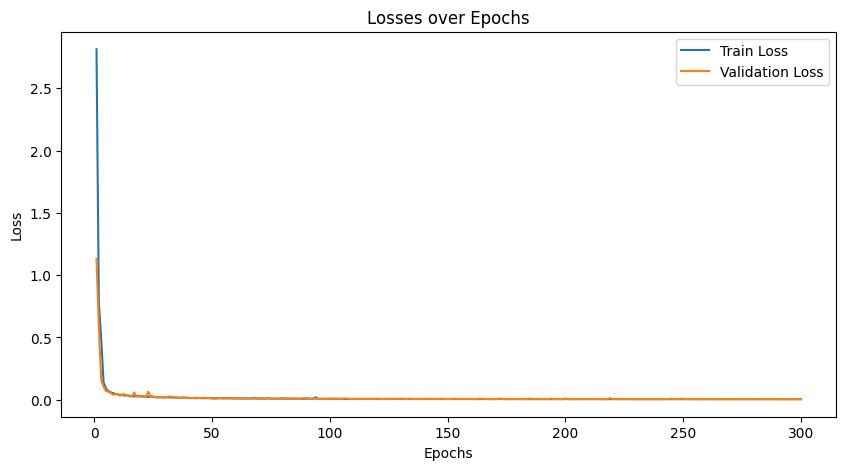

In [13]:
def plot_losses(train_loss, val_loss):
    epochs = np.arange(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


plot_losses(history_xavier["train_loss"], history_xavier["val_loss"])

In [64]:
def calculate_model_performance(model_name):
    """Calculate and print model performance metrics"""
    if "Xavier" in model_name:
        model = LinearlyActuatedStrutsXavier()
    elif "Compact" in model_name:
        model = LinearlyActuatedStrutsHeCompact()
    elif "Deep" in model_name:
        model = DeepLinearlyActuatedStruts()
    else:
        model = LinearlyActuatedStrutsHe()
    model.load_state_dict(torch.load(f'best_{model_name}.pth'))
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
    
    # Rescale predictions back to [0, 73.8]
    pred_real = predictions * 73.8
    
    # Calculate metrics
    # mse = nn.L1Loss()(pred_real, y_test * 73.8).item()
    mae = torch.mean(torch.abs(pred_real - y_test * 73.8)).item()
    
    print(f"Model: {model_name} | MAE: {mae:.4f}")
    return pred_real, mae


xavier_pred, xavier_mae = calculate_model_performance("Xavier_Model_1e-3")

Model: Xavier_Model_1e-3 | MAE: 0.3312


In [17]:
xavier_pred = torch.round(xavier_pred, decimals=1)
print(xavier_pred)

tensor([[73.7000, 73.8000, 73.8000,  0.2000, 73.5000, 56.5000],
        [14.9000, 73.8000, 73.4000, 73.0000, 73.5000, 73.6000],
        [73.7000, 73.7000, 73.8000, 73.2000, 68.1000,  0.1000],
        ...,
        [73.4000, 73.6000, 73.7000, 36.4000,  0.1000,  0.1000],
        [73.5000, 73.6000, 73.8000, 72.8000,  5.5000,  0.0000],
        [73.4000, 73.5000, 73.7000, 63.2000,  0.0000,  0.0000]])


In [18]:
y_test_scaled = y_test * 73.8
print(y_test_scaled)

tensor([[73.8000, 73.8000, 73.8000,  0.1400, 73.2900, 55.1800],
        [13.4900, 73.8000, 73.8000, 73.2200, 73.8000, 73.8000],
        [73.8000, 73.8000, 73.8000, 73.2200, 67.5900,  0.0000],
        ...,
        [73.8000, 73.8000, 73.8000, 36.3500,  0.0000,  0.0000],
        [73.5800, 73.5100, 73.6500, 72.5700,  4.3200,  0.0000],
        [73.8000, 73.8000, 73.8000, 63.2600,  0.0000,  0.0000]])


Now we will try with smaller learning rates

In [19]:
model_xavier_2 = LinearlyActuatedStrutsXavier()

# Train and evaluate
history_xavier_2 = train_model(
    model=model_xavier_2,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="Xavier_Model_5e-4",
    num_epochs=600,
    scale_factor=73.8,  # Your specific scaling factor
    lr= 5e-4,  # Learning rate for the second model
)

# Access results
print(f"Best validation loss with Xavier Initialization and Learning rate of 5e-4: {history_xavier_2['best_val_loss']:.4f} at epoch {history_xavier_2['epoch_best']}")

Epoch 1/600 | Train Loss: 3.9927 | Val Loss: 1.5046
Epoch 11/600 | Train Loss: 0.0579 | Val Loss: 0.0529
Epoch 21/600 | Train Loss: 0.0286 | Val Loss: 0.0276
Epoch 31/600 | Train Loss: 0.0244 | Val Loss: 0.0234
Epoch 41/600 | Train Loss: 0.0179 | Val Loss: 0.0235
Epoch 51/600 | Train Loss: 0.0161 | Val Loss: 0.0151
Epoch 61/600 | Train Loss: 0.0146 | Val Loss: 0.0129
Epoch 71/600 | Train Loss: 0.0135 | Val Loss: 0.0111
Epoch 81/600 | Train Loss: 0.0111 | Val Loss: 0.0104
Epoch 91/600 | Train Loss: 0.0104 | Val Loss: 0.0103
Epoch 101/600 | Train Loss: 0.0094 | Val Loss: 0.0085
Epoch 111/600 | Train Loss: 0.0092 | Val Loss: 0.0087
Epoch 121/600 | Train Loss: 0.0091 | Val Loss: 0.0072
Epoch 131/600 | Train Loss: 0.0082 | Val Loss: 0.0115
Epoch 141/600 | Train Loss: 0.0087 | Val Loss: 0.0078
Epoch 151/600 | Train Loss: 0.0074 | Val Loss: 0.0079
Epoch 161/600 | Train Loss: 0.0073 | Val Loss: 0.0198
Epoch 171/600 | Train Loss: 0.0066 | Val Loss: 0.0075
Epoch 181/600 | Train Loss: 0.0063 | Va

In [52]:
xavier_pred_2, xavier_mae_2 = calculate_model_performance("Xavier_Model_5e-4")

Model: Xavier_Model_5e-4 | MAE: 0.3369


Now we will try with He initialization

In [66]:
model_he = LinearlyActuatedStrutsHe()
# Train and evaluate
history_he = train_model(
    model=model_he,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="He_Model_1e-3",
    num_epochs=700,
    scale_factor=73.8  # Your specific scaling factor
)

print(f"Best validation loss with He Initialization: {history_he['best_val_loss']:.4f} at epoch {history_he['epoch_best']}")

Epoch 1/700 | Train Loss: 2.4090 | Val Loss: 1.0830
Epoch 11/700 | Train Loss: 0.0388 | Val Loss: 0.0485
Epoch 21/700 | Train Loss: 0.0246 | Val Loss: 0.0213
Epoch 31/700 | Train Loss: 0.0141 | Val Loss: 0.0126
Epoch 41/700 | Train Loss: 0.0098 | Val Loss: 0.0078
Epoch 51/700 | Train Loss: 0.0079 | Val Loss: 0.0077
Epoch 61/700 | Train Loss: 0.0071 | Val Loss: 0.0065
Epoch 71/700 | Train Loss: 0.0138 | Val Loss: 0.0419
Epoch 81/700 | Train Loss: 0.0062 | Val Loss: 0.0079
Epoch 91/700 | Train Loss: 0.0066 | Val Loss: 0.0064
Epoch 101/700 | Train Loss: 0.0051 | Val Loss: 0.0052
Epoch 111/700 | Train Loss: 0.0050 | Val Loss: 0.0048
Epoch 121/700 | Train Loss: 0.0053 | Val Loss: 0.0061
Epoch 131/700 | Train Loss: 0.0047 | Val Loss: 0.0058
Epoch 141/700 | Train Loss: 0.0047 | Val Loss: 0.0046
Epoch 151/700 | Train Loss: 0.0046 | Val Loss: 0.0049
Epoch 161/700 | Train Loss: 0.0053 | Val Loss: 0.0050
Epoch 171/700 | Train Loss: 0.0041 | Val Loss: 0.0047
Epoch 181/700 | Train Loss: 0.0043 | Va

In [67]:
he_pred, he_mae = calculate_model_performance("He_Model_1e-3")

he_pred = torch.round(he_pred, decimals=1)
print(he_pred)

Model: He_Model_1e-3 | MAE: 0.2949
tensor([[73.8000, 73.8000, 73.8000,  0.1000, 73.5000, 56.8000],
        [14.0000, 73.8000, 73.4000, 72.9000, 73.3000, 73.8000],
        [73.6000, 73.7000, 73.7000, 73.4000, 67.8000,  0.0000],
        ...,
        [73.4000, 73.6000, 73.7000, 36.3000,  0.0000,  0.0000],
        [73.6000, 73.6000, 73.7000, 72.8000,  4.2000,  0.0000],
        [73.4000, 73.6000, 73.7000, 62.9000,  0.0000,  0.0000]])


In [25]:
he_model_2 = LinearlyActuatedStrutsHe()
# Train and evaluate
history_he_2 = train_model(
    model=he_model_2,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="He_Model_5e-4",
    num_epochs=600,
    scale_factor=73.8,  # Your specific scaling factor
    lr= 5e-4,  # Learning rate for the second model
)

print(f"Best validation loss with He Initialization and Learning rate of 5e-4: {history_he_2['best_val_loss']:.4f} at epoch {history_he_2['epoch_best']}")

Epoch 1/600 | Train Loss: 3.2758 | Val Loss: 1.4228
Epoch 11/600 | Train Loss: 0.0537 | Val Loss: 0.0423
Epoch 21/600 | Train Loss: 0.0260 | Val Loss: 0.0342
Epoch 31/600 | Train Loss: 0.0213 | Val Loss: 0.0165
Epoch 41/600 | Train Loss: 0.0152 | Val Loss: 0.0143
Epoch 51/600 | Train Loss: 0.0117 | Val Loss: 0.0118
Epoch 61/600 | Train Loss: 0.0112 | Val Loss: 0.0108
Epoch 71/600 | Train Loss: 0.0098 | Val Loss: 0.0141
Epoch 81/600 | Train Loss: 0.0078 | Val Loss: 0.0106
Epoch 91/600 | Train Loss: 0.0070 | Val Loss: 0.0081
Epoch 101/600 | Train Loss: 0.0069 | Val Loss: 0.0068
Epoch 111/600 | Train Loss: 0.0069 | Val Loss: 0.0080
Epoch 121/600 | Train Loss: 0.0061 | Val Loss: 0.0058
Epoch 131/600 | Train Loss: 0.0062 | Val Loss: 0.0076
Epoch 141/600 | Train Loss: 0.0055 | Val Loss: 0.0057
Epoch 151/600 | Train Loss: 0.0054 | Val Loss: 0.0050
Epoch 161/600 | Train Loss: 0.0050 | Val Loss: 0.0071
Epoch 171/600 | Train Loss: 0.0052 | Val Loss: 0.0049
Epoch 181/600 | Train Loss: 0.0050 | Va

In [56]:
he_pred_2, he_mae_2 = calculate_model_performance("He_Model_5e-4")

he_pred_2 = torch.round(he_pred_2, decimals=1)
print(he_pred_2)


Model: He_Model_5e-4 | MAE: 0.3238
tensor([[73.7000, 73.8000, 73.8000,  0.1000, 73.6000, 56.5000],
        [14.5000, 73.8000, 73.3000, 72.9000, 73.5000, 73.6000],
        [73.6000, 73.6000, 73.6000, 73.2000, 67.5000,  0.1000],
        ...,
        [73.4000, 73.6000, 73.7000, 35.2000,  0.0000,  0.0000],
        [73.6000, 73.5000, 73.7000, 72.8000,  4.7000,  0.0000],
        [73.4000, 73.5000, 73.7000, 62.8000,  0.0000,  0.0000]])


In [41]:
he_model_3 = LinearlyActuatedStrutsHe()
# Train and evaluate
history_he_3 = train_model(
    model=he_model_3,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="He_Model_5e-3",
    num_epochs=600,
    scale_factor=73.8,  # Your specific scaling factor
    lr= 5e-3,  # Learning rate for the second model
)

print(f"Best validation loss with He Initialization and Learning rate of 5e-3: {history_he_3['best_val_loss']:.4f} at epoch {history_he_3['epoch_best']}")

Epoch 1/600 | Train Loss: 1.5473 | Val Loss: 0.1270
Epoch 11/600 | Train Loss: 0.0274 | Val Loss: 0.0216
Epoch 21/600 | Train Loss: 0.0126 | Val Loss: 0.0141
Epoch 31/600 | Train Loss: 0.0165 | Val Loss: 0.0080
Epoch 41/600 | Train Loss: 0.0094 | Val Loss: 0.0083
Epoch 51/600 | Train Loss: 0.0075 | Val Loss: 0.0075
Epoch 61/600 | Train Loss: 0.0075 | Val Loss: 0.0101
Epoch 71/600 | Train Loss: 0.0115 | Val Loss: 0.0094
Epoch 81/600 | Train Loss: 0.0074 | Val Loss: 0.0173
Epoch 91/600 | Train Loss: 0.0061 | Val Loss: 0.0105
Epoch 101/600 | Train Loss: 0.0112 | Val Loss: 0.0060
Epoch 111/600 | Train Loss: 0.0062 | Val Loss: 0.0061
Epoch 121/600 | Train Loss: 0.0061 | Val Loss: 0.0064
Epoch 131/600 | Train Loss: 0.0086 | Val Loss: 0.0070
Epoch 141/600 | Train Loss: 0.0056 | Val Loss: 0.0057
Epoch 151/600 | Train Loss: 0.0062 | Val Loss: 0.0064
Epoch 161/600 | Train Loss: 0.0054 | Val Loss: 0.0056
Epoch 171/600 | Train Loss: 0.0074 | Val Loss: 0.0074
Epoch 181/600 | Train Loss: 0.0054 | Va

In [57]:
he_model_3_pred_3, he_mae_3 = calculate_model_performance("He_Model_5e-3")
he_model_3_pred_3 = torch.round(he_model_3_pred_3, decimals=1)
print(he_model_3_pred_3)


Model: He_Model_5e-3 | MAE: 0.3278
tensor([[73.8000, 73.8000, 73.8000,  0.0000, 73.5000, 56.7000],
        [13.0000, 73.6000, 73.7000, 72.8000, 73.4000, 73.8000],
        [73.7000, 73.7000, 73.8000, 73.3000, 67.5000,  0.0000],
        ...,
        [73.5000, 73.5000, 73.7000, 36.1000,  0.0000,  0.0000],
        [73.5000, 73.7000, 73.7000, 72.6000,  4.8000,  0.0000],
        [73.3000, 73.6000, 73.6000, 62.8000,  0.0000,  0.0000]])


In [36]:
he_lr_decay = LinearlyActuatedStrutsHe()

he_lr_decay_history = train_model(
    model=he_lr_decay,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="He_Model_LR_Decay",
    num_epochs=600,
    scale_factor=73.8,  # Your specific scaling factor
    # lr= 5e-4,  # Learning rate for the second model
    optimizer = torch.optim.AdamW(he_lr_decay.parameters(), lr=1e-3, weight_decay=0.01)
)
print(f"Best validation loss with He Initialization and Learning rate decay: {history_he_2['best_val_loss']:.4f} at epoch {history_he_2['epoch_best']}")

Epoch 1/600 | Train Loss: 2.4109 | Val Loss: 1.0850
Epoch 11/600 | Train Loss: 0.0364 | Val Loss: 0.0327
Epoch 21/600 | Train Loss: 0.0214 | Val Loss: 0.0168
Epoch 31/600 | Train Loss: 0.0130 | Val Loss: 0.0106
Epoch 41/600 | Train Loss: 0.0087 | Val Loss: 0.0070
Epoch 51/600 | Train Loss: 0.0089 | Val Loss: 0.0100
Epoch 61/600 | Train Loss: 0.0072 | Val Loss: 0.0077
Epoch 71/600 | Train Loss: 0.0193 | Val Loss: 0.0430
Epoch 81/600 | Train Loss: 0.0061 | Val Loss: 0.0063
Epoch 91/600 | Train Loss: 0.0059 | Val Loss: 0.0060
Epoch 101/600 | Train Loss: 0.0053 | Val Loss: 0.0053
Epoch 111/600 | Train Loss: 0.0050 | Val Loss: 0.0053
Epoch 121/600 | Train Loss: 0.0046 | Val Loss: 0.0052
Epoch 131/600 | Train Loss: 0.0047 | Val Loss: 0.0053
Epoch 141/600 | Train Loss: 0.0048 | Val Loss: 0.0050
Epoch 151/600 | Train Loss: 0.0052 | Val Loss: 0.0048
Epoch 161/600 | Train Loss: 0.0047 | Val Loss: 0.0051
Epoch 171/600 | Train Loss: 0.0043 | Val Loss: 0.0049
Epoch 181/600 | Train Loss: 0.0042 | Va

In [58]:
he_decay_, he_decay_mae = calculate_model_performance("He_Model_LR_Decay")

he_decay_ = torch.round(he_decay_, decimals=1)
print(he_decay_)


Model: He_Model_LR_Decay | MAE: 0.3319
tensor([[73.7000, 73.8000, 73.8000,  0.1000, 73.5000, 56.7000],
        [14.5000, 73.8000, 73.4000, 73.0000, 73.5000, 73.6000],
        [73.6000, 73.6000, 73.7000, 73.4000, 67.6000,  0.0000],
        ...,
        [73.4000, 73.5000, 73.7000, 35.8000,  0.0000,  0.1000],
        [73.5000, 73.5000, 73.6000, 72.8000,  4.7000,  0.1000],
        [73.4000, 73.6000, 73.7000, 62.6000,  0.0000,  0.0000]])


In [39]:
he_compact = LinearlyActuatedStrutsHeCompact()

he_compact_history = train_model(
    model=he_compact,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="He_Model_LR_Compact",
    num_epochs=600,
    scale_factor=73.8,  # Your specific scaling factor
    lr= 1e-3,  # Learning rate for the second model
)

print(f"Best validation loss with He Initialization and Compact Model: {he_compact_history['best_val_loss']:.4f} at epoch {he_compact_history['epoch_best']}")

Epoch 1/600 | Train Loss: 3.2627 | Val Loss: 1.7551
Epoch 11/600 | Train Loss: 0.3843 | Val Loss: 0.3889
Epoch 21/600 | Train Loss: 0.0312 | Val Loss: 0.0478
Epoch 31/600 | Train Loss: 0.0259 | Val Loss: 0.0252
Epoch 41/600 | Train Loss: 0.0174 | Val Loss: 0.0166
Epoch 51/600 | Train Loss: 0.0161 | Val Loss: 0.0136
Epoch 61/600 | Train Loss: 0.0179 | Val Loss: 0.0166
Epoch 71/600 | Train Loss: 0.0139 | Val Loss: 0.0108
Epoch 81/600 | Train Loss: 0.0108 | Val Loss: 0.0105
Epoch 91/600 | Train Loss: 0.0101 | Val Loss: 0.0145
Epoch 101/600 | Train Loss: 0.0089 | Val Loss: 0.0093
Epoch 111/600 | Train Loss: 0.0090 | Val Loss: 0.0121
Epoch 121/600 | Train Loss: 0.0099 | Val Loss: 0.0087
Epoch 131/600 | Train Loss: 0.0077 | Val Loss: 0.0092
Epoch 141/600 | Train Loss: 0.0081 | Val Loss: 0.0069
Epoch 151/600 | Train Loss: 0.0073 | Val Loss: 0.0071
Epoch 161/600 | Train Loss: 0.0072 | Val Loss: 0.0091
Epoch 171/600 | Train Loss: 0.0064 | Val Loss: 0.0081
Epoch 181/600 | Train Loss: 0.0069 | Va

In [59]:
he_compact_pred, he_compact_mae = calculate_model_performance("He_Model_LR_Compact")
he_compact_pred = torch.round(he_compact_pred, decimals=1)
print(he_compact_pred)

Model: He_Model_LR_Compact | MAE: 0.3541
tensor([[73.7000, 73.7000, 73.7000,  0.3000, 73.6000, 56.5000],
        [12.7000, 73.8000, 73.3000, 73.0000, 73.3000, 73.8000],
        [73.8000, 73.8000, 73.8000, 73.3000, 68.1000,  0.2000],
        ...,
        [73.8000, 73.6000, 73.8000, 35.9000,  0.0000,  0.1000],
        [73.8000, 73.6000, 73.8000, 72.9000,  4.5000,  0.0000],
        [73.8000, 73.5000, 73.8000, 62.6000,  0.0000,  0.0000]])


In [47]:
model_he = LinearlyActuatedStrutsHe()
# Train and evaluate
history_he = train_model(
    model=model_he,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="He_Model_1e-3WeightDecay",
    num_epochs=500,
    scale_factor=73.8,  # Your specific scaling factor
    optimizer = torch.optim.Adam(model_he.parameters(), lr=1e-3, weight_decay=1e-6)
)

print(f"Best validation loss with He Initialization: {history_he['best_val_loss']:.4f} at epoch {history_he['epoch_best']}")

Epoch 1/500 | Train Loss: 2.4069 | Val Loss: 1.0775
Epoch 11/500 | Train Loss: 0.0356 | Val Loss: 0.0314
Epoch 21/500 | Train Loss: 0.0246 | Val Loss: 0.0333
Epoch 31/500 | Train Loss: 0.0147 | Val Loss: 0.0142
Epoch 41/500 | Train Loss: 0.0135 | Val Loss: 0.0101
Epoch 51/500 | Train Loss: 0.0115 | Val Loss: 0.0127
Epoch 61/500 | Train Loss: 0.0094 | Val Loss: 0.0094
Epoch 71/500 | Train Loss: 0.0094 | Val Loss: 0.0091
Epoch 81/500 | Train Loss: 0.0083 | Val Loss: 0.0100
Epoch 91/500 | Train Loss: 0.0098 | Val Loss: 0.0083
Epoch 101/500 | Train Loss: 0.0077 | Val Loss: 0.0082
Epoch 111/500 | Train Loss: 0.0074 | Val Loss: 0.0071
Epoch 121/500 | Train Loss: 0.0079 | Val Loss: 0.0066
Epoch 131/500 | Train Loss: 0.0071 | Val Loss: 0.0066
Epoch 141/500 | Train Loss: 0.0071 | Val Loss: 0.0067
Epoch 151/500 | Train Loss: 0.0072 | Val Loss: 0.0067
Epoch 161/500 | Train Loss: 0.0069 | Val Loss: 0.0082
Epoch 171/500 | Train Loss: 0.0070 | Val Loss: 0.0068
Epoch 181/500 | Train Loss: 0.0064 | Va

In [50]:
model_he_pred, model_he_mae = calculate_model_performance("He_Model_1e-3")
model_he_pred = torch.round(model_he_pred, decimals=1)
print(model_he_pred)


Model: He_Model_1e-3 | MAE: 0.3057
tensor([[73.8000, 73.8000, 73.8000,  0.1000, 73.5000, 56.7000],
        [13.2000, 73.8000, 73.3000, 73.1000, 73.3000, 73.8000],
        [73.6000, 73.7000, 73.7000, 73.2000, 68.0000,  0.0000],
        ...,
        [73.4000, 73.6000, 73.7000, 36.5000,  0.0000,  0.0000],
        [73.6000, 73.6000, 73.7000, 72.8000,  4.1000,  0.0000],
        [73.4000, 73.6000, 73.7000, 63.2000,  0.0000,  0.0000]])


In [63]:
deep_nn = DeepLinearlyActuatedStruts()
# Train and evaluate
history_deep_nn = train_model(
    model=deep_nn,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="Deep_NN_Model",
    num_epochs=200,
    scale_factor=73.8,  # Your specific scaling factor
    lr=1e-3,  # Learning rate for the deep model
)

print(f"Best validation loss with Deep NN: {history_deep_nn['best_val_loss']:.4f} at epoch {history_deep_nn['epoch_best']}")

Epoch 1/200 | Train Loss: 2.2402 | Val Loss: 0.4957
Epoch 11/200 | Train Loss: 0.4450 | Val Loss: 0.1344
Epoch 21/200 | Train Loss: 0.3093 | Val Loss: 0.1196
Epoch 31/200 | Train Loss: 0.2342 | Val Loss: 0.1356
Epoch 41/200 | Train Loss: 0.2316 | Val Loss: 0.1168
Epoch 51/200 | Train Loss: 0.1979 | Val Loss: 0.2031
Epoch 61/200 | Train Loss: 0.1761 | Val Loss: 0.2867
Epoch 71/200 | Train Loss: 0.1532 | Val Loss: 0.0731
Epoch 81/200 | Train Loss: 0.1320 | Val Loss: 0.0805
Epoch 91/200 | Train Loss: 0.1430 | Val Loss: 0.0684
Epoch 101/200 | Train Loss: 0.1372 | Val Loss: 0.0913
Epoch 111/200 | Train Loss: 0.1208 | Val Loss: 0.0796
Epoch 121/200 | Train Loss: 0.1130 | Val Loss: 0.0580
Epoch 131/200 | Train Loss: 0.1106 | Val Loss: 0.0803
Epoch 141/200 | Train Loss: 0.1125 | Val Loss: 0.0894
Epoch 151/200 | Train Loss: 0.1030 | Val Loss: 0.0905
Epoch 161/200 | Train Loss: 0.1081 | Val Loss: 0.1344
Epoch 171/200 | Train Loss: 0.1035 | Val Loss: 0.0920
Epoch 181/200 | Train Loss: 0.0990 | Va

In [65]:
deep_nn_pred, deep_nn_mae = calculate_model_performance("Deep_NN_Model")

deep_nn_pred = torch.round(deep_nn_pred, decimals=1)
print(deep_nn_pred)


Model: Deep_NN_Model | MAE: 1.7180
tensor([[73.8000, 73.8000, 73.8000,  1.6000, 73.8000, 52.9000],
        [17.9000, 73.7000, 73.5000, 73.7000, 73.8000, 73.8000],
        [73.7000, 72.3000, 73.5000, 72.5000, 66.8000,  1.7000],
        ...,
        [73.8000, 73.8000, 73.8000, 34.6000,  0.2000,  1.0000],
        [73.8000, 73.7000, 73.8000, 71.0000,  8.8000,  1.3000],
        [73.8000, 73.8000, 73.8000, 60.0000,  1.1000,  1.5000]])


He init 3 hidden layer 1e-3 and L1 regularization

In [70]:
he_l1 = LinearlyActuatedStrutsHe()
# Train and evaluate with L1 regularization
history_he_l1 = train_model(
    model=he_l1,
    train_loader=train_loader,
    val_loader=val_loader,
    model_name="He_Model_L1",
    num_epochs=700,
    scale_factor=73.8,  # Your specific scaling factor
    l1_lambda=1e-5,  # L1 regularization strength
)
print(f"Best validation loss with He Initialization and L1 regularization: {history_he_l1['best_val_loss']:.4f} at epoch {history_he_l1['epoch_best']}")

Epoch 1/700 | Train Loss: 3.9237 | Val Loss: 1.0925
Epoch 11/700 | Train Loss: 0.5533 | Val Loss: 0.0824
Epoch 21/700 | Train Loss: 0.3257 | Val Loss: 0.0518
Epoch 31/700 | Train Loss: 0.2659 | Val Loss: 0.0419
Epoch 41/700 | Train Loss: 0.2361 | Val Loss: 0.0387
Epoch 51/700 | Train Loss: 0.2153 | Val Loss: 0.0373
Epoch 61/700 | Train Loss: 0.2024 | Val Loss: 0.0371
Epoch 71/700 | Train Loss: 0.1960 | Val Loss: 0.0359
Epoch 81/700 | Train Loss: 0.1884 | Val Loss: 0.0365
Epoch 91/700 | Train Loss: 0.1826 | Val Loss: 0.0334
Epoch 101/700 | Train Loss: 0.1788 | Val Loss: 0.0352
Epoch 111/700 | Train Loss: 0.1761 | Val Loss: 0.0360
Epoch 121/700 | Train Loss: 0.1751 | Val Loss: 0.0349
Epoch 131/700 | Train Loss: 0.1728 | Val Loss: 0.0320
Epoch 141/700 | Train Loss: 0.1706 | Val Loss: 0.0319
Epoch 151/700 | Train Loss: 0.1708 | Val Loss: 0.0326
Epoch 161/700 | Train Loss: 0.1696 | Val Loss: 0.0334
Epoch 171/700 | Train Loss: 0.1670 | Val Loss: 0.0320
Epoch 181/700 | Train Loss: 0.1659 | Va